# Valence analysis on Spotify tracks
___
> Iraklis Chatzinikolaou

## Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import glob
import re
from datetime import datetime

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

- We unzip the files and create a dataframe

In [2]:
header = 0
dfs = []
for file in glob.glob('charts/Charts/*/201?/*.csv'):
    region = file.split('\\')[1] #split 
    dates = re.findall('\d{4}-\d{2}-\d{2}', file.split('\\')[-1])
    weekly_chart = pd.read_csv(file, header=header, sep='\t')
    weekly_chart['week_start'] = datetime.strptime(dates[0], '%Y-%m-%d')
    weekly_chart['week_end'] = datetime.strptime(dates[1], '%Y-%m-%d')
    weekly_chart['region'] = region
    dfs.append(weekly_chart)
    
all_charts = pd.concat(dfs)    


In [3]:
all_charts.head()

,position,song_id,song_name,artist,streams,last_week_position,weeks_on_chart,peak_position,position_status,week_start,week_end,region
0,1,5aAx2yezTd8zXrkmtKl66Z,Starboy,The Weeknd,947261,NaN,1,1,new,2016-12-30,2017-01-06,au
1,2,5knuzwU65gJK7IF5yJsuaW,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,893107,NaN,1,2,new,2016-12-30,2017-01-06,au
2,3,7BKLCZ1jbUBVqRi2FVlTVw,Closer,The Chainsmokers,871617,NaN,1,3,new,2016-12-30,2017-01-06,au
3,4,3NdDpSvN911VPGivFlV5d0,I Don’t Wanna Live Forever (Fifty Shades Darke...,ZAYN,791592,NaN,1,4,new,2016-12-30,2017-01-06,au
4,5,78rIJddV4X0HkNAInEcYde,Call On Me - Ryan Riback Extended Remix,Starley,743490,NaN,1,5,new,2016-12-30,2017-01-06,au


- The above is the list of tracks we want to predict the valence of. We check its unique tracks

In [4]:
all_charts['song_id'].nunique()

13880

-  A `spotify_config.py` file is created with the following:<br>
      <code>config = {
          'client_id' : 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX',
          'client_secret' :'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
     }<code>
    
- We use the Spotify API via the [Spotipy](https://spotipy.readthedocs.io/en/2.22.1/) library 

In [4]:
from spotify_config import config

client_credentials_manager = SpotifyClientCredentials(config['client_id'],
                                                      config['client_secret'])
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [5]:
features = {}

all_track_ids = list(all_charts['song_id'].unique())
start=0
num_tracks = 100
while start < len(all_track_ids):
    print(f'getting from {start} to {start+num_tracks}')
    tracks_batch = all_track_ids[start:start+num_tracks]
    features_batch = sp.audio_features(tracks_batch)
    features.update({track_id : track_features for track_id, track_features in zip(tracks_batch, features_batch)})
    start += num_tracks

getting from 0 to 100
getting from 100 to 200
getting from 200 to 300
getting from 300 to 400
getting from 400 to 500
getting from 500 to 600
getting from 600 to 700
getting from 700 to 800
getting from 800 to 900
getting from 900 to 1000
getting from 1000 to 1100
getting from 1100 to 1200
getting from 1200 to 1300
getting from 1300 to 1400
getting from 1400 to 1500
getting from 1500 to 1600
getting from 1600 to 1700
getting from 1700 to 1800
getting from 1800 to 1900
getting from 1900 to 2000
getting from 2000 to 2100
getting from 2100 to 2200
getting from 2200 to 2300
getting from 2300 to 2400
getting from 2400 to 2500
getting from 2500 to 2600
getting from 2600 to 2700
getting from 2700 to 2800
getting from 2800 to 2900
getting from 2900 to 3000
getting from 3000 to 3100
getting from 3100 to 3200
getting from 3200 to 3300
getting from 3300 to 3400
getting from 3400 to 3500
getting from 3500 to 3600
getting from 3600 to 3700
getting from 3700 to 3800
getting from 3800 to 3900
getting

In [6]:
#check if we got all of the tracks
len(features)

13880

- Since the above are dictionaries we convert them to dataframe
- We set the id index as a column and match its name with the one of all_charts

In [7]:
tracks = pd.DataFrame.from_dict(features,orient='index')
tracks = tracks.reset_index(drop=True).rename(columns={'id' : 'song_id'})
tracks.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,song_id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.681,0.594,7,-7.028,1,0.2820,0.1650,0.000003,0.134,0.5350,186.054,audio_features,5aAx2yezTd8zXrkmtKl66Z,spotify:track:5aAx2yezTd8zXrkmtKl66Z,https://api.spotify.com/v1/tracks/5aAx2yezTd8z...,https://api.spotify.com/v1/audio-analysis/5aAx...,230453,4
1,0.720,0.763,9,-4.068,0,0.0523,0.4060,0.000000,0.180,0.7420,101.965,audio_features,5knuzwU65gJK7IF5yJsuaW,spotify:track:5knuzwU65gJK7IF5yJsuaW,https://api.spotify.com/v1/tracks/5knuzwU65gJK...,https://api.spotify.com/v1/audio-analysis/5knu...,251088,4
2,0.748,0.524,8,-5.599,1,0.0338,0.4140,0.000000,0.111,0.6610,95.010,audio_features,7BKLCZ1jbUBVqRi2FVlTVw,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,https://api.spotify.com/v1/tracks/7BKLCZ1jbUBV...,https://api.spotify.com/v1/audio-analysis/7BKL...,244960,4
3,0.735,0.451,0,-8.374,1,0.0585,0.0631,0.000013,0.325,0.0862,117.973,audio_features,3NdDpSvN911VPGivFlV5d0,spotify:track:3NdDpSvN911VPGivFlV5d0,https://api.spotify.com/v1/tracks/3NdDpSvN911V...,https://api.spotify.com/v1/audio-analysis/3NdD...,245200,4
4,0.670,0.838,0,-4.031,1,0.0362,0.0604,0.000611,0.159,0.7170,104.998,audio_features,78rIJddV4X0HkNAInEcYde,spotify:track:78rIJddV4X0HkNAInEcYde,https://api.spotify.com/v1/tracks/78rIJddV4X0H...,https://api.spotify.com/v1/audio-analysis/78rI...,222041,4


- Drop irrelevant and categorical columns
- Check the info of the dataframe to only by numerical for our regression task

In [8]:
tracks.drop(["type", "uri" , "track_href" , "analysis_url"], axis = 1, inplace = True)
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13880 entries, 0 to 13879
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      13880 non-null  float64
 1   energy            13880 non-null  float64
 2   key               13880 non-null  int64  
 3   loudness          13880 non-null  float64
 4   mode              13880 non-null  int64  
 5   speechiness       13880 non-null  float64
 6   acousticness      13880 non-null  float64
 7   instrumentalness  13880 non-null  float64
 8   liveness          13880 non-null  float64
 9   valence           13880 non-null  float64
 10  tempo             13880 non-null  float64
 11  song_id           13880 non-null  object 
 12  duration_ms       13880 non-null  int64  
 13  time_signature    13880 non-null  int64  
dtypes: float64(9), int64(4), object(1)
memory usage: 1.5+ MB


In [11]:
tracks.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,song_id,duration_ms,time_signature
0,0.681,0.594,7,-7.028,1,0.2820,0.1650,0.000003,0.134,0.5350,186.054,5aAx2yezTd8zXrkmtKl66Z,230453,4
1,0.720,0.763,9,-4.068,0,0.0523,0.4060,0.000000,0.180,0.7420,101.965,5knuzwU65gJK7IF5yJsuaW,251088,4
2,0.748,0.524,8,-5.599,1,0.0338,0.4140,0.000000,0.111,0.6610,95.010,7BKLCZ1jbUBVqRi2FVlTVw,244960,4
3,0.735,0.451,0,-8.374,1,0.0585,0.0631,0.000013,0.325,0.0862,117.973,3NdDpSvN911VPGivFlV5d0,245200,4
4,0.670,0.838,0,-4.031,1,0.0362,0.0604,0.000611,0.159,0.7170,104.998,78rIJddV4X0HkNAInEcYde,222041,4


- Now we insert the test sample

In [9]:
track_ids = pd.read_csv('spotify_ids.txt', header=None)
track_ids = track_ids.rename(columns={0:'song_id'})
track_ids.head()

,song_id
0,7lPN2DXiMsVn7XUKtOW1CS
1,5QO79kh1waicV47BqGRL3g
2,0VjIjW4GlUZAMYd2vXMi3b
3,4MzXwWMhyBbmu6hOcLVD49
4,5Kskr9LcNYa0tpt5f0ZEJx


In [13]:
track_ids.nunique()

song_id    1162
dtype: int64

In [10]:
len(track_ids)

1162

- We are gonna follow the same procedure like above 

In [10]:
features_test = {}

tracks_ids = list(track_ids['song_id'])
start=0
num_tracks = 100
while start < len(track_ids):
    print(f'getting from {start} to {start+num_tracks}')
    tracks_batch = tracks_ids[start:start+num_tracks]
    features_batch = sp.audio_features(tracks_batch)
    features_test.update({track_id : track_features for track_id, track_features in zip(tracks_batch, features_batch)})
    start += num_tracks

getting from 0 to 100
getting from 100 to 200
getting from 200 to 300
getting from 300 to 400
getting from 400 to 500
getting from 500 to 600
getting from 600 to 700
getting from 700 to 800
getting from 800 to 900
getting from 900 to 1000
getting from 1000 to 1100
getting from 1100 to 1200


In [11]:
len(features_test)

1162

In [17]:
features_test['5Kskr9LcNYa0tpt5f0ZEJx']

{'danceability': 0.907,
 'energy': 0.393,
 'key': 4,
 'loudness': -7.636,
 'mode': 0,
 'speechiness': 0.0539,
 'acousticness': 0.451,
 'instrumentalness': 1.35e-06,
 'liveness': 0.135,
 'valence': 0.202,
 'tempo': 104.949,
 'type': 'audio_features',
 'id': '5Kskr9LcNYa0tpt5f0ZEJx',
 'uri': 'spotify:track:5Kskr9LcNYa0tpt5f0ZEJx',
 'track_href': 'https://api.spotify.com/v1/tracks/5Kskr9LcNYa0tpt5f0ZEJx',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/5Kskr9LcNYa0tpt5f0ZEJx',
 'duration_ms': 205458,
 'time_signature': 4}

In [12]:
test_tracks = pd.DataFrame.from_dict(features_test,orient='index')
test_tracks = test_tracks.reset_index(drop=True).rename(columns={'id' : 'song_id'})

test_tracks.drop(["type", "uri" , "track_href" , "analysis_url"], axis = 1, inplace = True)
test_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162 entries, 0 to 1161
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      1162 non-null   float64
 1   energy            1162 non-null   float64
 2   key               1162 non-null   int64  
 3   loudness          1162 non-null   float64
 4   mode              1162 non-null   int64  
 5   speechiness       1162 non-null   float64
 6   acousticness      1162 non-null   float64
 7   instrumentalness  1162 non-null   float64
 8   liveness          1162 non-null   float64
 9   valence           1162 non-null   float64
 10  tempo             1162 non-null   float64
 11  song_id           1162 non-null   object 
 12  duration_ms       1162 non-null   int64  
 13  time_signature    1162 non-null   int64  
dtypes: float64(9), int64(4), object(1)
memory usage: 127.2+ KB


In [14]:
test_tracks.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,song_id,duration_ms,time_signature
0,0.585,0.436,10,-8.761,1,0.0601,0.72100,0.000013,0.1050,0.132,143.874,7lPN2DXiMsVn7XUKtOW1CS,242014,4
1,0.680,0.826,0,-5.487,1,0.0309,0.02120,0.000012,0.5430,0.644,118.051,5QO79kh1waicV47BqGRL3g,215627,4
2,0.514,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,0VjIjW4GlUZAMYd2vXMi3b,200040,4
3,0.731,0.573,4,-10.059,0,0.0544,0.40100,0.000052,0.1130,0.145,109.928,4MzXwWMhyBbmu6hOcLVD49,205090,4
4,0.907,0.393,4,-7.636,0,0.0539,0.45100,0.000001,0.1350,0.202,104.949,5Kskr9LcNYa0tpt5f0ZEJx,205458,4


## Valence prediction without the use of Neural Networks

In [13]:
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

- create the test and training sets from the above df's

In [14]:
X_train = tracks.drop(['song_id', 'valence'], axis=1).values
y_train = tracks['valence'].values

X_test = test_tracks.drop(['song_id', 'valence'], axis=1).values
y_test = test_tracks['valence'].values

sscaler= StandardScaler()
mscaler=MinMaxScaler()
X_train_sscaled = sscaler.fit_transform(X_train)
X_test_sscaled = sscaler.transform(X_test)
X_train_mscaled = mscaler.fit_transform(X_train)
X_test_mscaled = mscaler.transform(X_test)

- Recall we don't want data leakge from the test set so we only fit on the X_train data.

### Method 1: Desicion Trees

- Desicion trees does not need to be scaled hence we import the raw data

In [22]:
clf = DecisionTreeRegressor()
tracks_tree = clf.fit(X_train, y_train)

predictions = tracks_tree.predict(X_test)
mean_absolute_error(y_test,predictions)

0.189937091222031

- We found the mean absolute error to be `mae = 0,187`, which is a fair result for a 1st try
- We can try adding an optimizer to the model

In [22]:
parameters = {
    'criterion': ['absolute_error'],
    'max_depth': list(range(2, 7)),
}

cv=KFold(n_splits=5, shuffle=True)
grid_searc = GridSearchCV(DecisionTreeRegressor(), param_grid=parameters, cv=cv,n_jobs=-1)

tracks_tree = grid_searc.fit(X_train, y_train)
print(tracks_tree.best_estimator_)
print(tracks_tree.best_params_)

DecisionTreeRegressor(criterion='absolute_error', max_depth=6)
{'criterion': 'absolute_error', 'max_depth': 6}


In [23]:
predictions = tracks_tree.predict(X_test)
mean_absolute_error(y_test,predictions)

0.16181790017211703

- hence the mean absolute value is dropped to `mae = 0.1618`

### Method 2: KNN

In [24]:
knr = KNeighborsRegressor(n_jobs=-1)
knr.fit(X_train,y_train)

predictions = knr.predict(X_test)
mean_absolute_error(y_test,predictions)

0.1948577452667814

- vs the model with the normalised data

In [25]:
knr = KNeighborsRegressor(n_jobs=-1)
knr.fit(X_train_sscaled,y_train)

predictions = knr.predict(X_test_sscaled)
mean_absolute_error(y_test,predictions)

0.16640476764199658

- Now let's try and improve on the model with the normalised data

In [120]:
parameters = {
    'n_neighbors': np.arange(1,60),
    'weights': ['distance','uniform'],
    'p' : [1,2],
}

knr_tuned = GridSearchCV(knr, param_grid=parameters, n_jobs=-1)

knr_tuned = knr_tuned.fit(X_train_sscaled, y_train)
print(knr_tuned.best_estimator_)
print(knr_tuned.best_params_)

KNeighborsRegressor(n_jobs=-1, n_neighbors=54, p=1, weights='distance')
{'n_neighbors': 54, 'p': 1, 'weights': 'distance'}


In [121]:
knr_tuned_pred = knr_tuned.predict(X_test_sscaled)
mean_absolute_error(y_test,knr_tuned_pred)

0.14149026343470386

- This took an awful lot of time but it is the best model thus far with `mae = 0.14149`

### Method 3: Random Forests

In [28]:
rforest = RandomForestRegressor()
rforest.fit(X_train, y_train)

rforest_pred = rforest.predict(X_test)
mean_absolute_error(y_test,rforest_pred)

0.13830205048766495

- Trying to use GridSearchCV or RandomizedSearchCV takes an absurd amount of time for SVM and RF hence we will
    avoid doing that

### Method 4: Support Vector Machines

In [127]:
svr = SVR()
svr.fit(X_train, y_train)

svr_pred = svr.predict(X_test)
mean_absolute_error(y_test,svr_pred)

0.19242068037091975

- vs normalized data

In [128]:
svr = SVR()
svr.fit(X_train_sscaled, y_train)

svr_pred = svr.predict(X_test_sscaled)
mean_absolute_error(y_test,svr_pred)

0.14901188766447593

### Method 5: Linear Regression

In [26]:
lm = LinearRegression()
lm.fit(X_train,y_train)

predictions = lm.predict(X_test)
mean_absolute_error(y_test,predictions)

0.16040561496315273

## Valence prediction using Neural Networks

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping

In [68]:
model = Sequential()

# input layer
model.add(Dense(12,  activation='relu',input_shape=(X_train_mscaled.shape[1],)))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(6, activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(units=1))

# Compile model
model.compile(loss='mae', optimizer='adam',metrics = 'mean_absolute_error')

In [63]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 12)                156       
                                                                 
 dropout_18 (Dropout)        (None, 12)                0         
                                                                 
 dense_35 (Dense)            (None, 6)                 78        
                                                                 
 dropout_19 (Dropout)        (None, 6)                 0         
                                                                 
 dense_36 (Dense)            (None, 1)                 7         
                                                                 
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________


In [69]:
model.fit(
    x=X_train_mscaled, 
    y=y_train,
    epochs=100, 
    validation_data=(X_test_mscaled, y_test))

Epoch 1/100
434/434 [==============================] - 2s 2ms/step - loss: 0.3051 - mean_absolute_error: 0.3051 - val_loss: 0.1971 - val_mean_absolute_error: 0.1971
Epoch 2/100
434/434 [==============================] - 1s 2ms/step - loss: 0.1939 - mean_absolute_error: 0.1939 - val_loss: 0.1900 - val_mean_absolute_error: 0.1900
Epoch 3/100
434/434 [==============================] - 1s 2ms/step - loss: 0.1820 - mean_absolute_error: 0.1820 - val_loss: 0.1874 - val_mean_absolute_error: 0.1874
Epoch 4/100
434/434 [==============================] - 1s 2ms/step - loss: 0.1767 - mean_absolute_error: 0.1767 - val_loss: 0.1870 - val_mean_absolute_error: 0.1870
Epoch 5/100
434/434 [==============================] - 1s 2ms/step - loss: 0.1727 - mean_absolute_error: 0.1727 - val_loss: 0.1795 - val_mean_absolute_error: 0.1795
Epoch 6/100
434/434 [==============================] - 1s 2ms/step - loss: 0.1694 - mean_absolute_error: 0.1694 - val_loss: 0.1799 - val_mean_absolute_error: 0.1799
Epoch 7/10

In [70]:
losses = pd.DataFrame(model.history.history)

<Axes: >

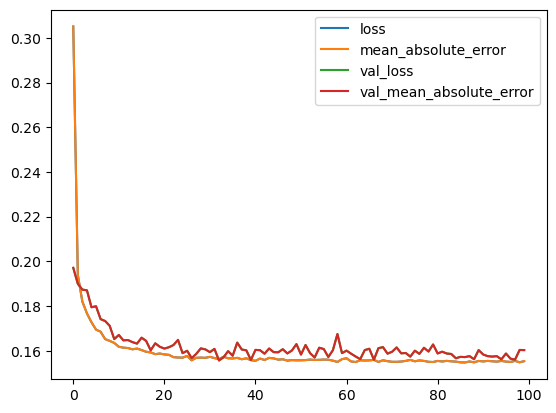

In [71]:
losses.plot()

In [73]:
y_pred = model.predict(X_test_mscaled)
mean_absolute_error(y_test,y_pred)

37/37 [==============================] - 0s 1ms/step


0.16028865967059505

In [41]:
y_test.shape

(1162,)

In [74]:
model = Sequential()

# input layer
model.add(Dense(12,  activation='relu',input_shape=(X_train_mscaled.shape[1],)))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(6, activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(units=1))

# Compile model
model.compile(loss='mae', optimizer='adam',metrics = 'mean_absolute_error')

In [75]:
early_stop = EarlyStopping(monitor='val_mean_absolute_error',patience=10)

In [76]:
model.fit(callbacks=[early_stop],
    x=X_train_mscaled, 
    y=y_train,
    epochs=100, 
    validation_data=(X_test_mscaled, y_test))

Epoch 1/100
434/434 [==============================] - 2s 2ms/step - loss: 0.2309 - mean_absolute_error: 0.2309 - val_loss: 0.1925 - val_mean_absolute_error: 0.1925
Epoch 2/100
434/434 [==============================] - 1s 2ms/step - loss: 0.1834 - mean_absolute_error: 0.1834 - val_loss: 0.1812 - val_mean_absolute_error: 0.1812
Epoch 3/100
434/434 [==============================] - 1s 2ms/step - loss: 0.1748 - mean_absolute_error: 0.1748 - val_loss: 0.1779 - val_mean_absolute_error: 0.1779
Epoch 4/100
434/434 [==============================] - 1s 2ms/step - loss: 0.1713 - mean_absolute_error: 0.1713 - val_loss: 0.1750 - val_mean_absolute_error: 0.1750
Epoch 5/100
434/434 [==============================] - 1s 2ms/step - loss: 0.1694 - mean_absolute_error: 0.1694 - val_loss: 0.1798 - val_mean_absolute_error: 0.1798
Epoch 6/100
434/434 [==============================] - 1s 2ms/step - loss: 0.1669 - mean_absolute_error: 0.1669 - val_loss: 0.1727 - val_mean_absolute_error: 0.1727
Epoch 7/10

<Axes: >

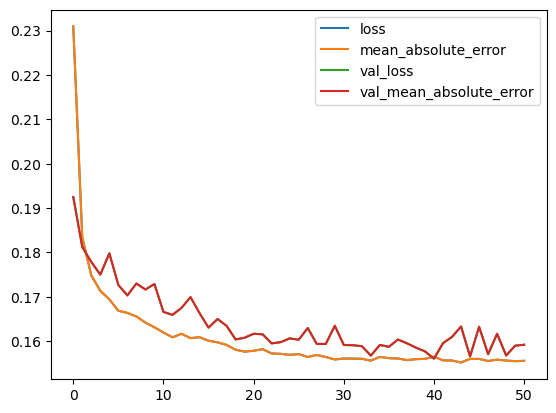

In [77]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [79]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 12)                156       
                                                                 
 dropout_22 (Dropout)        (None, 12)                0         
                                                                 
 dense_41 (Dense)            (None, 6)                 78        
                                                                 
 dropout_23 (Dropout)        (None, 6)                 0         
                                                                 
 dense_42 (Dense)            (None, 1)                 7         
                                                                 
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________


In [78]:
y_pred1 = model.predict(X_test_mscaled)
mean_absolute_error(y_test,y_pred1)

37/37 [==============================] - 0s 1ms/step


0.15918565473357496

- Below are shown all the results of this project

#### Non-neural networks

|       | Tree   | KNN    | SVR    | RanFor | LinReg |
|-------|--------|----|--------|--------|--------|
|__MAE__|0.1618  |0.1414  |0.149   | 0.1383 | 0.1604 |

#### Neural networks

|       | ANN-2layers   | ANN-dropout & early stop    |
|---|---|---|
|__MAE__|0.1602  |0.1585|

- Random forests seems to provide the best results compared to the other techniques including nn

- As known neural networks ran fast and efficiently and yield very good results in sort time